# CSE 256: NLP UCSD PA1:




## Text Classification with Logistic Regression and FF Networks(100points).

 The  goal of this assignment is  to get experience developing text classifiers with with linear models and simple feedforward
neural networks.  You will see the standard
pipeline used in many NLP tasks (reading in data, preprocessing, training, and testing).

*  Part 1: PyTorch Basics (25 points)
*  Part 2: Logistic Regression and Feedforward Neural Networks (60 points)
*  Part 3: Exploration (20 points)

Data. You will using a dataset of movie review snippets taken from IMDB.

### <font color='blue'> Due:  April 22, 2024 at  10pm </font>

###### IMPORTANT: After copying this notebook to your Google Drive, paste a link to it below. To get a publicly-accessible link, click the *Share* button at the top right, then click "Get shareable link" and copy the link.
#### <font color="red">Link: paste your link here:  </font>

---
**Notes:**

Make sure to save the notebook as you go along.

Submission instructions are located at the bottom of the notebook.

The code should run fairly quickly (a couple of minutes at most even without a GPU), if it takes much longer than that, its likely that you have introduced an error.

## Mount your Google Drive to Colab

**Note**: <font color="red"> TODO: you need to specify your working foldername in this cell below:

In [13]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

import warnings
import os
warnings.filterwarnings("ignore")
# TODO: Enter the foldername  in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cse256/assignments/PA1/'
FOLDERNAME = './'
assert FOLDERNAME is not None, "[!] Enter the foldername."

current_directory = os.getcwd()

# Construct the absolute path
absolute_path = os.path.join(current_directory, FOLDERNAME)

print(absolute_path)

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
sys.path.append(FOLDERNAME)

%cd $FOLDERNAME
# This is later used to use the IMDB reviews
# %cd /content/drive/My\ Drive/$FOLDERNAME/

F:\UCSD\Classes\3.CSE256\HW\CSE256\PA1\./
F:\UCSD\Classes\3.CSE256\HW\CSE256\PA1


# Part 1: PyTorch Basics (25 Points)

We will use PyTorch, a machine learning framework, for the programming assignmets in this course. The first part of this assigment focuses on  PyTorch and how it is used for NLP.
If you are new to [PyTorch](https://pytorch.org), it is highly recommended to go to work through  [the 60 minute tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

##Question 1.1 (2.5 points)

In state-of-the-art NLP, words are represented by low-dimensional vectors,  referred to as *embeddings*. When processing sequences such as sentences, movie, reviews, or entire paragraphs,   word embeddings are used to compute a vector representation of the sequence,  denoted by $\boldsymbol{x}$. In the cell below, the embeddings for the words in the sequence "Alice talked to" are provided. Your task is to combine these embeddings into a single vector representation $\boldsymbol{x}$, using  [element-wise vector addition](https://ml-cheatsheet.readthedocs.io/en/latest/linear_algebra.html#elementwise-operations). This method is a simple way to obtain a sequence representation, namely, it is a *continuous bag-of-words (BoW) representation* of a sequence.

In [14]:
import torch
#use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# This scipy_mode=False is used to avoid scientific notation
torch.set_printoptions(sci_mode=False)
# Seed the random number generator for reproducibility
torch.manual_seed(0)

input_sequence = 'I like NLP'

# Initialize an embedding matrix
# We have a vocabulary of 5 words, each represented by a 10-dimensional embedding vector.
embeddings = torch.nn.Embedding(num_embeddings=5, embedding_dim=10)
vocab = {'I': 0, 'like': 1, 'NLP': 2, 'classifiers': 3, '.': 4}

# Convert the word to integer indices. These indices will be used to
# retrieve the corresponding embeddings from the embedding matrix.
# In PyTorch, operations are performed on Tensor objects, so we need to  convert
# the list of indices to a LongTensor.
indices = torch.LongTensor([vocab[w] for w in input_sequence.split()])
input_sequence_embs = embeddings(indices)
print('sequence embedding tensor size: ', input_sequence_embs.size())

# The input_sequence_embs tensor contains the embeddings for each word in the input sequence.
# The next step is to aggregate these embeddings into a single vector representation.
# You will use element-wise addition to do this.
# Write the code to add the embeddings element-wise and store the result in the variable "x".

print(input_sequence_embs)
x = torch.sum(input_sequence_embs, dim=0)

### DO NOT MODIFY THE LINE BELOW
print('input sequence embedding sum (continuous BoW): ', x)


sequence embedding tensor size:  torch.Size([3, 10])
tensor([[-1.1258, -1.1524, -0.2506, -0.4339,  0.8487,  0.6920, -0.3160, -2.1152,
          0.3223, -1.2633],
        [ 0.3500,  0.3081,  0.1198,  1.2377,  1.1168, -0.2473, -1.3527, -1.6959,
          0.5667,  0.7935],
        [ 0.5988, -1.5551, -0.3414,  1.8530,  0.7502, -0.5855, -0.1734,  0.1835,
          1.3894,  1.5863]], grad_fn=<EmbeddingBackward0>)
input sequence embedding sum (continuous BoW):  tensor([-0.1770, -2.3993, -0.4721,  2.6568,  2.7157, -0.1408, -1.8421, -3.6277,
         2.2783,  1.1165], grad_fn=<SumBackward1>)


##Question 1.2 (2.5 points)
Element-wise addition is not the best way to aggregate individual word embeddings in a sequence into a single vector representation (a process known as *composition*). State one significant limitation of using element-wise addition as a composition function for word embeddings?
---

#### <font color="red">Write your answer here (2-3 sentences) </font>

One significant limitation of using element-wise addition to aggregate individual word embeddings into a single vector representation is that it does not preserve the order of words in the sequence. This means that sequences with the same words in different orders will result in the same aggregated embedding, potentially losing important syntactic and semantic information. Additionally, this method can lead to an issue known as "swamping," where frequent words overly influence the resulting vector, diminishing the contribution of less frequent but potentially more informative words.


##Question 1.3 (5 points)
The [softmax function](https://pytorch.org/docs/master/nn.functional.html#softmax) is used in nearly all the neural network architectures we will look at in this course. The softmax is computed on an $n$-dimensional vector $<x_1, x_2, \dots, x_n>$ as $\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{1 \leq j \leq n} e^{x_j}}$. Given the   sequence representation $\boldsymbol{x}$ we just computed, we can use the softmax function in combination with a linear projection using a matrix $W$ to transform $\boldsymbol{x}$ into a probability distribution $p$ over the next word, expressed as $p = \text{softmax}(W\boldsymbol{x})$. Let's look at this in the cell below:

In [15]:
# Initialize a random matrix W of size 10x5. This will serve as the weight matrix
# for the linear projection of the vector x into a 5-dimensional space.
W = torch.rand(10, 5)


# Project the vector x to a 5-dimensional space using the matrix W. This projection is achieved through
# matrix multiplication. After the projection, apply the softmax function to the result,
# which converts the 5-dimensional projected vector into a probability distribution.
# You can find the softmax function in PyTorch's  API (torch.nn.functional.softmax).
# Store the resulting probability distribution in the variable "probs".

projected_x = torch.matmul(W.T, x) 
probs = torch.nn.functional.softmax(projected_x, dim=0)


### DO NOT MODIFY THE BELOW LINE!
print('probability distribution', probs)


probability distribution tensor([0.0718, 0.0998, 0.1331, 0.6762, 0.0191], grad_fn=<SoftmaxBackward0>)


##Question 1.4 (5 points)

In the example so far, we focused on a single sequence ("I like NLP"). However, in practical applications, it’s common to process multiple sequences simultaneously. This practice, known as *batching*, allows for more efficient use of GPU parallelism. In batching, each sequence is considered an example within a larger batch

For this question, you will perform redo the previous computation, but with a batch of two sequences instead of just one. The final output of this cell should be a 2x5 matrix, where each row represents a probability distribution for a sequence. **Important: Avoid using loops in your solution, as you will lose points**. The code should be fully vectorized.

In [16]:
import torch
import torch.nn.functional as F

# For this example, we replicate our previous sequence indices to create a simple batch.
# Normally, each example in the batch would be different.
batch_indices = torch.cat(2 * [indices]).reshape((2, 3))
batch_embs = embeddings(batch_indices)
print('Batch embedding tensor size: ', batch_embs.size())

# To process the batch, follow these steps:
# Step 1: Aggregate the embeddings for each example in the batch into a single representation.
# This is done through element-wise addition. Use torch.sum with the appropriate 'dim' argument
# to sum across the sequence length (not the batch dimension).
batch_x = torch.sum(batch_embs, dim=1)

# Step 2: Project each aggregated representation into a 5-dimensional space using the matrix W.
# This involves matrix multiplication, ensuring the resulting batch has the shape 2x5.
batch_projected_x = torch.matmul(batch_x, W)

# Step 3: Apply the softmax function to the projected representations to obtain probability distributions.
# Each row in the output matrix should sum to 1, representing a probability distribution for each batch example.
batch_probs = F.softmax(batch_projected_x, dim=1)

### DO NOT MODIFY THE BELOW LINE
print("Batch probability distributions:", batch_probs)


Batch embedding tensor size:  torch.Size([2, 3, 10])
Batch probability distributions: tensor([[0.0718, 0.0998, 0.1331, 0.6762, 0.0191],
        [0.0718, 0.0998, 0.1331, 0.6762, 0.0191]], grad_fn=<SoftmaxBackward0>)



##Question 1.5 (5 points)

When processing a text sequence, how should the system handle words that are not present in the existing vocabulary? In the current implementation, the presence of such out-of-vocabulary words causes the code to fail, as in the cell below. To address this issue,  a simple solution is to use the special token `<UNK>`,  added to the vocabulary to serve as a placeholder for any unknown words.

Modify the indexing function to ensure that it checks each word against the known vocabulary and substitutes any out-of-vocabulary words with the `<UNK>` token.  Make sure not to add  any new words  to the vocabulary  except for the `<UNK>` token. Don't forget to adjust the embedding table.


In [17]:
import torch

torch.set_printoptions(sci_mode=False)
# Seed the random number generator for reproducibility
torch.manual_seed(0)

input_sequence = 'I like linear'


# Initialize an embedding matrix
# We have a vocabulary of 5 words, each represented by a 10-dimensional embedding vector.
embeddings = torch.nn.Embedding(num_embeddings=6, embedding_dim=10)
vocab = {'I': 0, 'like': 1, 'NLP': 2, 'classifiers': 3, '.': 4, '<UNK>': 5}


indices = torch.LongTensor([vocab[w] if w in vocab else vocab['<UNK>'] for w in input_sequence.split()]) ### MODIFY THIS INDEXING
input_sequence_embs = embeddings(indices)
print('sequence embedding tensor size: ', input_sequence_embs.size())



sequence embedding tensor size:  torch.Size([3, 10])


-------------------------------

# Part 2: Logisitic Regression and Feedforward Neural Networks (60 points)

In this part, you are going to experiment with Logistic Regression and Feedforward Neural Networks.  Run the starter code to train a two-layer fully connected neural network on the IMDB Sentiment Classification Dataset. The code provided below generates two plots that display the train accuracy and test accuracy. You will  build on code to produce different variants.


In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
import scipy.stats
import copy
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.feature_extraction.text import CountVectorizer

########## Neural network class
#
# Network of two fully connected layers
# with ReLU activation function and Softmax output
###########################################

class NN2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer.
        self.fc2 = nn.Linear(hidden_size, 2)  # Second fully connected layer, outputting two classes.

    # Define the forward pass of the neural network.
    # x: The input tensor.
    def forward(self, x):
        x = F.relu(self.fc1(x))  # Apply ReLU activation function after the first layer.
        x = self.fc2(x)  # Pass the result to the second layer.
        x = F.softmax(x, dim=1)  # Apply Softmax to obtain output probabilities.
        return x


In [19]:
######### ReviewsDataset class
#
# create a dataset to be used for training and evaluation
#########################
# Function to read reviews from a directory
def read_reviews(directory, num_reviews=1000):
    reviews = []
    for filename in os.listdir(directory)[:num_reviews]:  # Limit the number of files read
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            reviews.append(file.read())
    return reviews


class ReviewsDataset(Dataset):
    def __init__(self, pos_dir, neg_dir, num_reviews=1000, vectorizer=None, train=True):
        self.reviews = read_reviews(pos_dir, num_reviews) + read_reviews(neg_dir, num_reviews)
        self.labels = [1] * min(num_reviews, len(os.listdir(pos_dir))) + [0] * min(num_reviews, len(os.listdir(neg_dir)))
        if train or vectorizer is None:
            self.vectorizer = CountVectorizer(max_features=512)  # Adjust as needed
            self.embeddings = self.vectorizer.fit_transform(self.reviews).toarray()
        else:
            self.vectorizer = vectorizer
            self.embeddings = self.vectorizer.transform(self.reviews).toarray()

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


In [20]:
########## train_epoch
#
# function that trains for one epoch (one pass through the training set)
######################

def train_epoch(data_loader, model, loss_fn, optimizer):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        X = X.float()
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss


########## eval_epoch
#
# function that evaluates a model with a test set
######################
def eval_epoch(data_loader, model, loss_fn, optimizer):
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    model.eval()
    eval_loss = 0
    correct = 0
    for batch, (X, y) in enumerate(data_loader):
        # Compute prediction error
        X = X.float()
        pred = model(X)
        loss = loss_fn(pred, y)
        eval_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    average_eval_loss = eval_loss / num_batches
    accuracy = correct / size
    return accuracy, average_eval_loss



########## experiment
#
# function that trains a neural network with a training set
# and evaluates the neural network with a test set
#####################
def experiment(model):

	# negative log likelihood loss function
	loss_fn = nn.NLLLoss()

	# Adam optimizer
	optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

	average_train_loss = []
	all_train_accuracy = []
	average_test_loss = []
	all_test_accuracy = []
	for epoch in range(150):
		train_accuracy, train_loss = train_epoch(train_loader, model, loss_fn, optimizer)
		all_train_accuracy += [train_accuracy]
		test_accuracy, test_loss = eval_epoch(test_loader, model, loss_fn, optimizer)
		all_test_accuracy += [test_accuracy]
		if epoch % 10 == 9:
			print(f'Epoch #{epoch+1}: \t train accuracy {train_accuracy:.3f}\t train loss {train_loss:.3f}\t test accuracy {test_accuracy:.3f}\t test loss {test_loss:.3f}')
	return all_train_accuracy, all_test_accuracy


In [21]:
######################
#
# 1) Load data splits: the train and test sets
# 2) Train neural networks
# 3) Plot the results
############################

start_time = time.time()

# Load the dataset
root_dir = './CSE256_PA1/aclImdb/train'.format(FOLDERNAME)
root_dir_test = './CSE256_PA1/aclImdb/test'.format(FOLDERNAME)
train_dataset = ReviewsDataset(root_dir+'/pos', root_dir+'/neg', train=True)
test_dataset = ReviewsDataset(root_dir_test+'/pos', root_dir_test+'/neg', vectorizer=train_dataset.vectorizer, train=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time to load data: {elapsed_time} seconds")

Time to load data: 0.5920195579528809 seconds



2 layers:
Epoch #10: 	 train accuracy 0.875	 train loss -0.807	 test accuracy 0.795	 test loss -0.744
Epoch #20: 	 train accuracy 0.916	 train loss -0.874	 test accuracy 0.801	 test loss -0.772
Epoch #30: 	 train accuracy 0.936	 train loss -0.908	 test accuracy 0.792	 test loss -0.775
Epoch #40: 	 train accuracy 0.951	 train loss -0.929	 test accuracy 0.778	 test loss -0.772
Epoch #50: 	 train accuracy 0.958	 train loss -0.942	 test accuracy 0.776	 test loss -0.771
Epoch #60: 	 train accuracy 0.962	 train loss -0.949	 test accuracy 0.777	 test loss -0.770
Epoch #70: 	 train accuracy 0.965	 train loss -0.958	 test accuracy 0.773	 test loss -0.769
Epoch #80: 	 train accuracy 0.966	 train loss -0.962	 test accuracy 0.776	 test loss -0.771
Epoch #90: 	 train accuracy 0.967	 train loss -0.964	 test accuracy 0.773	 test loss -0.770
Epoch #100: 	 train accuracy 0.968	 train loss -0.966	 test accuracy 0.770	 test loss -0.769
Epoch #110: 	 train accuracy 0.968	 train loss -0.967	 test accuracy

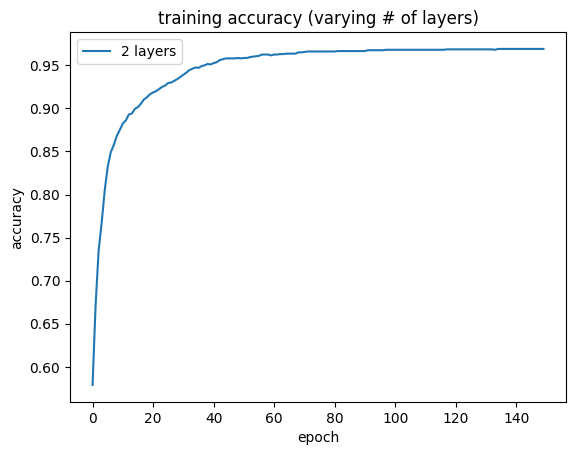

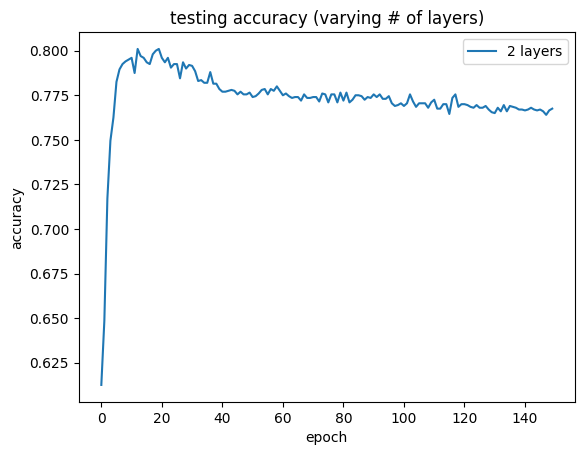

Time to train, eval model: 18.701429843902588 seconds


In [22]:
start_time = time.time()

# train neural networks
print('\n2 layers:')
nn2_train_accuracy, nn2_test_accuracy = experiment(NN2(input_size=512, hidden_size=100))

# plot training accuracy
plt.plot(nn2_train_accuracy)
plt.title('training accuracy (varying # of layers)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['2 layers'])
plt.show()

# plot testing accuracy
plt.plot(nn2_test_accuracy)
plt.title('testing accuracy (varying # of layers)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['2 layers'])
plt.show()


end_time = time.time()
elapsed_time = end_time - start_time

print(f"Time to train, eval model: {elapsed_time} seconds")

### <font color="red">  TO DO: Impelementation

- Implement and test fully connected networks with 1,2,3, and 4 layers. The starter code above already provides you with an implementation of 2 layers. Each hidden layer should have 100 nodes.
-  On the four layer network, modify the code to replace the ReLU activation function with the sigmoid activation function.
- On the four layer network, modify your code to insert a dropout layer with probability 0.5 after each hidden leayer. Tip: see the function nn.dropout().


In [23]:
class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, activation='relu', dropout_prob=0.0):
        super().__init__()
        self.activation = activation
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob
        layers = []
        sizes = [input_size] + [hidden_size] * (num_layers - 1) + [2]
        
        print(sizes)
        for i in range(num_layers):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob))
        
        self.layers = nn.Sequential(*layers[:-1])  # Exclude the last activation or dropout for the output layer

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = F.softmax(x, dim=1)  # Apply Softmax to obtain output probabilities.
        return x


## Question 2.1 Architecture Comparison (20 points)

Generate two plots where the y-axis is the accuracy and the x-axis is the # of epochs. The first plot should include 4 curves that show the training accuracy for 1, 2, 3, and 4 layers. The second plot should include 4 curves that show the testing accuracy for 1, 2, 3, and 4 layers. Use ReLU activation functions without any dropout and 100 nodes per hidden layer. Discuss the results.

[512, 2]
[512, 100, 2]
[512, 100, 100, 2]
[512, 100, 100, 100, 2]
[512, 100, 100, 100, 2]
Training model with 1 layers, relu activation, and dropout probability 0.0
Epoch #10: 	 train accuracy 0.780	 train loss -0.647	 test accuracy 0.741	 test loss -0.627
Epoch #20: 	 train accuracy 0.832	 train loss -0.711	 test accuracy 0.774	 test loss -0.673
Epoch #30: 	 train accuracy 0.853	 train loss -0.749	 test accuracy 0.789	 test loss -0.698
Epoch #40: 	 train accuracy 0.864	 train loss -0.774	 test accuracy 0.793	 test loss -0.715
Epoch #50: 	 train accuracy 0.872	 train loss -0.793	 test accuracy 0.795	 test loss -0.728
Epoch #60: 	 train accuracy 0.881	 train loss -0.807	 test accuracy 0.797	 test loss -0.737
Epoch #70: 	 train accuracy 0.888	 train loss -0.818	 test accuracy 0.798	 test loss -0.744
Epoch #80: 	 train accuracy 0.894	 train loss -0.828	 test accuracy 0.797	 test loss -0.749
Epoch #90: 	 train accuracy 0.897	 train loss -0.835	 test accuracy 0.797	 test loss -0.753
Epoch #

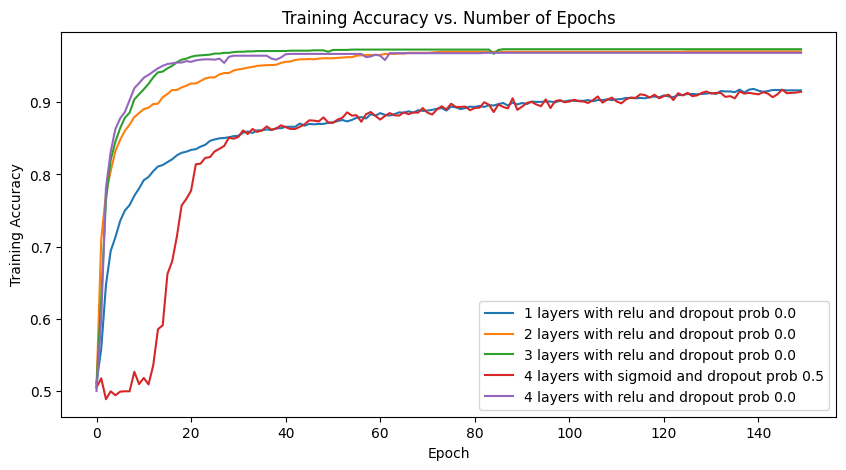

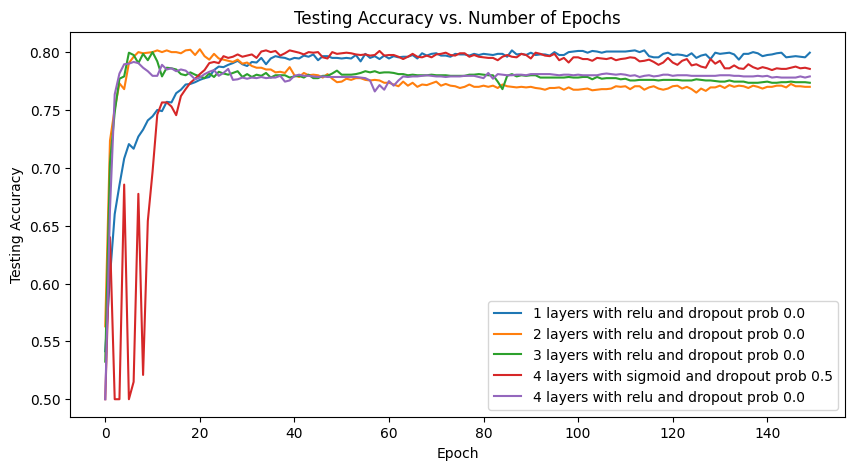

In [24]:
nn1 = CustomNN(input_size=512, hidden_size=100, num_layers=1)
nn2 = CustomNN(input_size=512, hidden_size=100, num_layers=2)
nn3 = CustomNN(input_size=512, hidden_size=100, num_layers=3)
nn4_sigmoid = CustomNN(input_size=512, hidden_size=100, num_layers=4, activation='sigmoid', dropout_prob=0.5)
nn4_relu = CustomNN(input_size=512, hidden_size=100, num_layers=4, activation='relu')

models = [nn1, nn2, nn3, nn4_sigmoid, nn4_relu]
train_accuracies = []
test_accuracies = []
i = 1

for model in models:
    print(f'Training model with {model.num_layers} layers, {model.activation} activation, and dropout probability {model.dropout_prob}') 
    i += 1
    train_acc, test_acc = experiment(model)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plot training accuracies
plt.figure(figsize=(10, 5))
for model, acc in zip(models, train_accuracies):
    label = f'{model.num_layers} layers with {model.activation} and dropout prob {model.dropout_prob}'
    plt.plot(acc, label=label)
plt.title('Training Accuracy vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

# Plot testing accuracies
plt.figure(figsize=(10, 5))
for model, acc in zip(models, test_accuracies):
    label = f'{model.num_layers} layers with {model.activation} and dropout prob {model.dropout_prob}'
    plt.plot(acc, label=label)
plt.title('Testing Accuracy vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Testing Accuracy')
plt.legend()
plt.show()

#### <font color="red">Analysis and discussion here (< 5 sentences) :</font>

From the training accuracy graph, we observe that networks with more layers tend to reach higher accuracy faster. All configurations plateau around the same accuracy, with the 3-layer network slightly outperforming others. Notably, the 4-layer network with a sigmoid activation function and 0.5 dropout probability starts lower but reaches a comparable final accuracy, suggesting that dropout helps prevent overfitting and allows the network to generalize better, despite initial underperformance.

The testing accuracy graph shows that the networks with ReLU activation without dropout generalize similarly, regardless of the number of layers. The 4-layer network with sigmoid and dropout appears to have the least overfitting due to a smaller gap between training and testing accuracy. Despite fluctuations during initial epochs, all networks stabilize, with no clear overfitting indicated by the close alignment of training and testing curves.

## Question 2.2 Activation functions (20 points)

 Generate two plots where the y-axis is the accuracy and the x-axis is the # of epochs. The first plot should include 2 curves that show the training accuracy when using the ReLU versus sigmoid activation functions. The second plot should include 2 curves that show the testing accuracy when using the ReLU versus sigmoid activation functions. Use 2 layers and 100 nodes per hidden layer without any dropout. Discuss the results.

[512, 100, 2]
[512, 100, 2]
Epoch #10: 	 train accuracy 0.875	 train loss -0.812	 test accuracy 0.804	 test loss -0.746
Epoch #20: 	 train accuracy 0.925	 train loss -0.878	 test accuracy 0.793	 test loss -0.771
Epoch #30: 	 train accuracy 0.946	 train loss -0.911	 test accuracy 0.791	 test loss -0.775
Epoch #40: 	 train accuracy 0.952	 train loss -0.931	 test accuracy 0.785	 test loss -0.774
Epoch #50: 	 train accuracy 0.961	 train loss -0.945	 test accuracy 0.777	 test loss -0.772
Epoch #60: 	 train accuracy 0.964	 train loss -0.953	 test accuracy 0.781	 test loss -0.774
Epoch #70: 	 train accuracy 0.966	 train loss -0.959	 test accuracy 0.778	 test loss -0.774
Epoch #80: 	 train accuracy 0.967	 train loss -0.963	 test accuracy 0.778	 test loss -0.773
Epoch #90: 	 train accuracy 0.968	 train loss -0.965	 test accuracy 0.775	 test loss -0.772
Epoch #100: 	 train accuracy 0.969	 train loss -0.967	 test accuracy 0.777	 test loss -0.773
Epoch #110: 	 train accuracy 0.970	 train loss -0.9

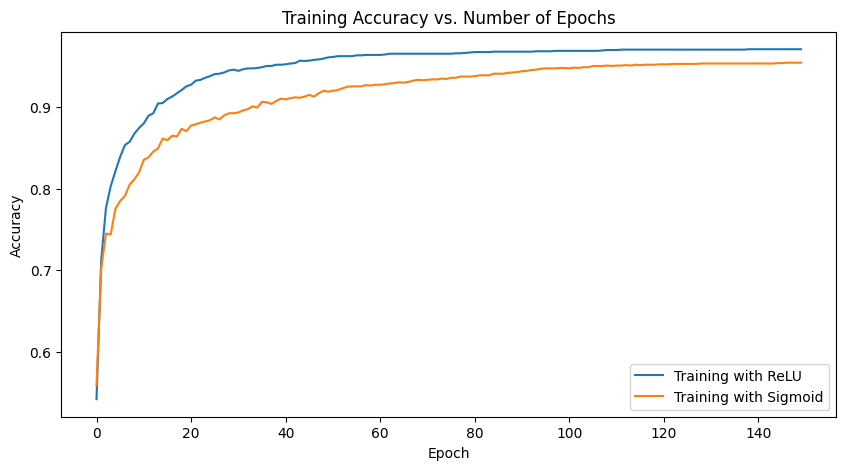

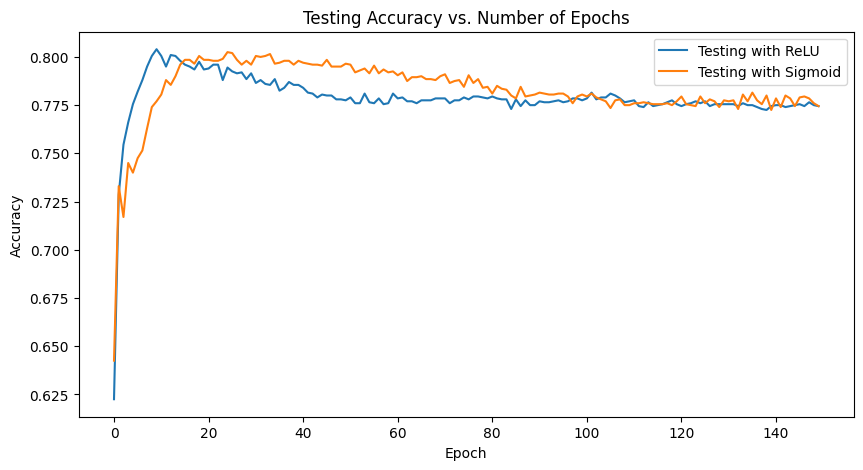

In [25]:
# Setting up models with different activations
relu_model = CustomNN(input_size=512, hidden_size=100, num_layers=2, activation='relu')
sigmoid_model = CustomNN(input_size=512, hidden_size=100, num_layers=2, activation='sigmoid')

train_relu, test_relu = experiment(relu_model)
train_sigmoid, test_sigmoid = experiment(sigmoid_model)

#print the shape of the train_relu and test_relu
print(np.shape(train_relu))

# Extract accuracies from the nested lists for ReLU
relu_train_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(train_relu)]
relu_test_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(test_relu)]

sigmoid_train_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(train_sigmoid)]
sigmoid_test_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(test_sigmoid)]

# Plot training accuracies
plt.figure(figsize=(10, 5))
plt.plot(relu_train_accuracies, label='Training with ReLU')
plt.plot(sigmoid_train_accuracies, label='Training with Sigmoid')
plt.title('Training Accuracy vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot testing accuracies
plt.figure(figsize=(10, 5))
plt.plot(relu_test_accuracies, label='Testing with ReLU')
plt.plot(sigmoid_test_accuracies, label='Testing with Sigmoid')
plt.title('Testing Accuracy vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### <font color="red">Analysis and discussion here (< 5 sentences) :</font>

In the training accuracy graph, the model using ReLU activation converges faster and achieves a slightly higher final accuracy than the model using Sigmoid activation. This is consistent with the well-known advantage of ReLU in accelerating the convergence of stochastic gradient descent compared to the Sigmoid function due to its non-saturating nature.

The testing accuracy graph reveals that both models generalize similarly to new data, with ReLU having a marginal edge. The Sigmoid model's performance is a bit more volatile, which could be due to the vanishing gradient problem, making it more sensitive to the choice of initial weights and learning rate.

## Question 2.3 Dropout comparison (15 points)

Generate two plots where the y-axis is the accuracy and the x-axis is the # of epochs. The first plot should include 2 curves that show the training accuracy with and without dropout (with probability 0.5) after each hidden layer. The second plot should include 2 curves that show the testing accuracy with and without dropout (with probability 0.5) after each hidden layer. Use 4 layers and 36 nodes per hidden layer with ReLU activation functions. Discuss the results.

[512, 36, 36, 36, 2]
[512, 36, 36, 36, 2]
Epoch #10: 	 train accuracy 0.562	 train loss -0.534	 test accuracy 0.577	 test loss -0.538
Epoch #20: 	 train accuracy 0.802	 train loss -0.679	 test accuracy 0.781	 test loss -0.683
Epoch #30: 	 train accuracy 0.854	 train loss -0.816	 test accuracy 0.795	 test loss -0.779
Epoch #40: 	 train accuracy 0.890	 train loss -0.870	 test accuracy 0.802	 test loss -0.796
Epoch #50: 	 train accuracy 0.911	 train loss -0.896	 test accuracy 0.797	 test loss -0.798
Epoch #60: 	 train accuracy 0.927	 train loss -0.916	 test accuracy 0.795	 test loss -0.795
Epoch #70: 	 train accuracy 0.934	 train loss -0.928	 test accuracy 0.795	 test loss -0.795
Epoch #80: 	 train accuracy 0.941	 train loss -0.936	 test accuracy 0.796	 test loss -0.794
Epoch #90: 	 train accuracy 0.952	 train loss -0.947	 test accuracy 0.795	 test loss -0.794
Epoch #100: 	 train accuracy 0.951	 train loss -0.948	 test accuracy 0.795	 test loss -0.796
Epoch #110: 	 train accuracy 0.956	 t

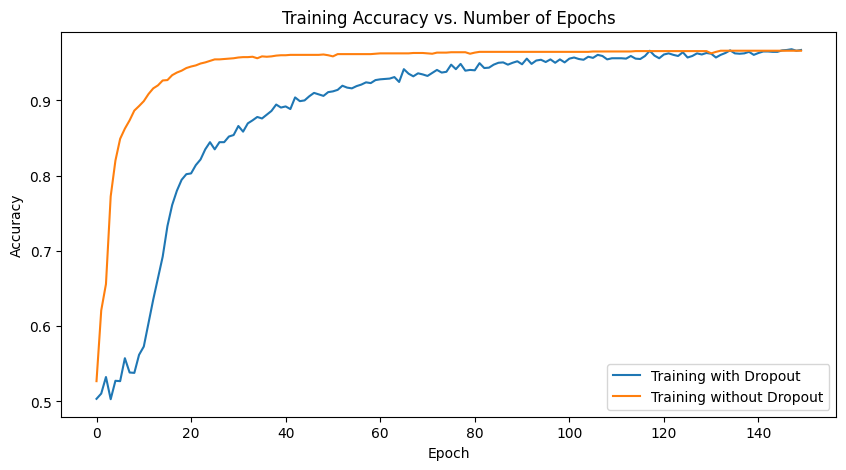

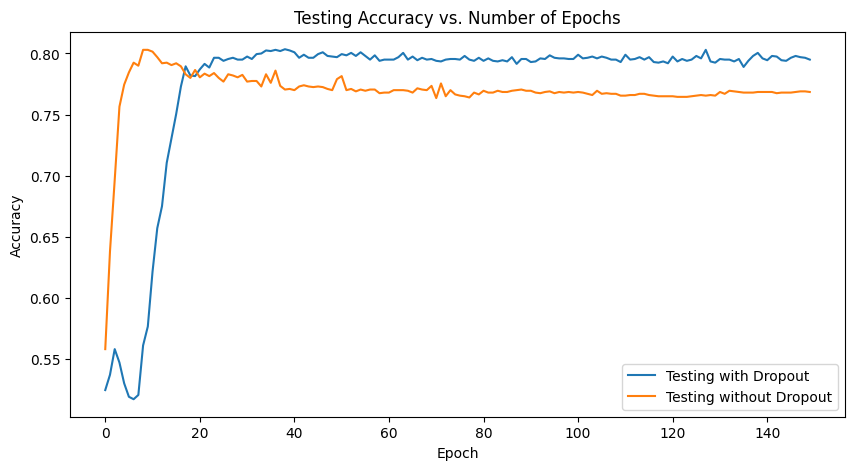

In [26]:
model_withdropout = CustomNN(input_size=512, hidden_size=36, num_layers=4, activation='relu', dropout_prob=0.5)
model_withoutdropout = CustomNN(input_size=512, hidden_size=36, num_layers=4, activation='relu', dropout_prob=0)

train_dropout, test_dropout = experiment(model_withdropout)
train_nodropout, test_nodropout = experiment(model_withoutdropout)

dropout_train_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(train_dropout)]
dropout_test_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(test_dropout)]

nodropout_train_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(train_nodropout)]
nodropout_test_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(test_nodropout)]

# Plot training accuracies
plt.figure(figsize=(10, 5))
plt.plot(dropout_train_accuracies, label='Training with Dropout')
plt.plot(nodropout_train_accuracies, label='Training without Dropout')
plt.title('Training Accuracy vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot testing accuracies
plt.figure(figsize=(10, 5))
plt.plot(dropout_test_accuracies, label='Testing with Dropout')
plt.plot(nodropout_test_accuracies, label='Testing without Dropout')
plt.title('Testing Accuracy vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### <font color="red">Analysis and discussion here (< 5 sentences) :</font>

In the training accuracy plot, the model without dropout converges to a higher accuracy more quickly compared to the model with dropout. This is a common consequence of dropout, as it is a form of regularization that prevents overfitting by randomly "dropping" a subset of features during each training epoch.

However, when we observe the testing accuracy, both models achieve similar accuracy, with the dropout model showing slightly more stability in its performance over epochs. This stability is indicative of better generalization to unseen data, a desired effect of using dropout. The model without dropout exhibits minor fluctuations, suggesting it may have overfit the training data slightly, although not severely.


## Question 2.4  (5 points)

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Pick all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.



#### <font color="red">Answer here </font>:

1 and 3

#### <font color="red">Explanation (< 5 sentences) here: </font>:
Train on a larger dataset: Increasing the amount of training data can help the model learn more generalizable patterns rather than memorizing the specifics of a smaller dataset. This is often effective in reducing overfitting.
Increase the regularization strength: Regularization techniques (such as L1, L2 regularization, or dropout) add constraints to the network that discourage complex models. This is done by penalizing the loss function for large weights or by randomly dropping units during training, which helps to prevent the model from fitting too closely to the training data.

# Part 3: Exploration  (20 points)

## Question 3.1 Explore  (20 points)

There are other aspects to optimizing neural network performance. Explore two here, and discuss your findings. You may also try different neural architures here, other than feedforward networks.

### Add a learning rate scheduler

In [27]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

def experiment_with_scheduler(model, train_loader, test_loader, epochs=150, learning_rate=0.0001, log_interval=10, step_size=30, gamma=0.1):
    
    # Loss and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Initialize scheduler
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    # Metrics
    all_train_accuracy = []
    all_test_accuracy = []
    
    for epoch in range(epochs):
        train_accuracy, train_loss = train_epoch(train_loader, model, loss_fn, optimizer)
        test_accuracy, test_loss = eval_epoch(test_loader, model, loss_fn, optimizer)
        
        all_train_accuracy.append(train_accuracy)
        all_test_accuracy.append(test_accuracy)
        
        # Update learning rate
        scheduler.step()
        
        if epoch % log_interval == log_interval - 1:
            print(f'Epoch #{epoch + 1}: train accuracy {train_accuracy:.3f}, train loss {train_loss:.3f}, test accuracy {test_accuracy:.3f}, test loss {test_loss:.3f}')
    
    return all_train_accuracy, all_test_accuracy


[512, 100, 100, 100, 2]
[512, 100, 100, 100, 2]
Epoch #10: train accuracy 0.767, train loss -0.687, test accuracy 0.777, test loss -0.715
Epoch #20: train accuracy 0.871, train loss -0.851, test accuracy 0.802, test loss -0.792
Epoch #30: train accuracy 0.911, train loss -0.894, test accuracy 0.792, test loss -0.790
Epoch #40: train accuracy 0.912, train loss -0.902, test accuracy 0.796, test loss -0.793
Epoch #50: train accuracy 0.911, train loss -0.902, test accuracy 0.789, test loss -0.791
Epoch #60: train accuracy 0.919, train loss -0.907, test accuracy 0.793, test loss -0.792
Epoch #70: train accuracy 0.924, train loss -0.911, test accuracy 0.793, test loss -0.792
Epoch #80: train accuracy 0.915, train loss -0.904, test accuracy 0.791, test loss -0.791
Epoch #90: train accuracy 0.910, train loss -0.907, test accuracy 0.791, test loss -0.791
Epoch #100: train accuracy 0.923, train loss -0.913, test accuracy 0.791, test loss -0.791
Epoch #110: train accuracy 0.919, train loss -0.909

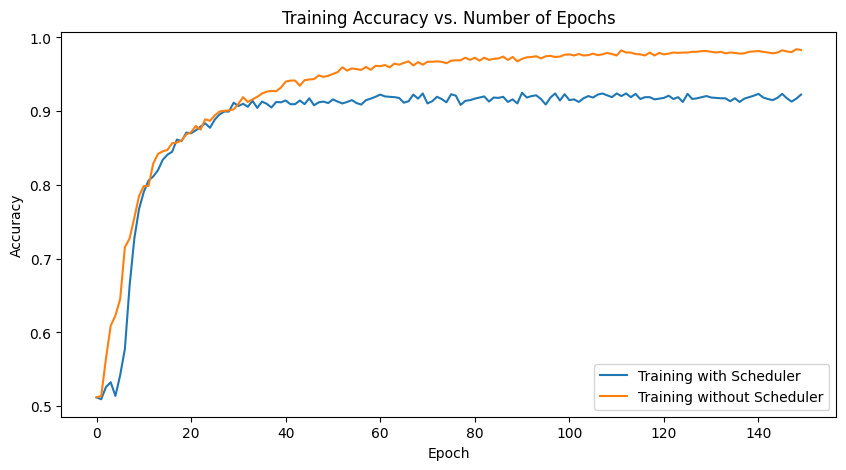

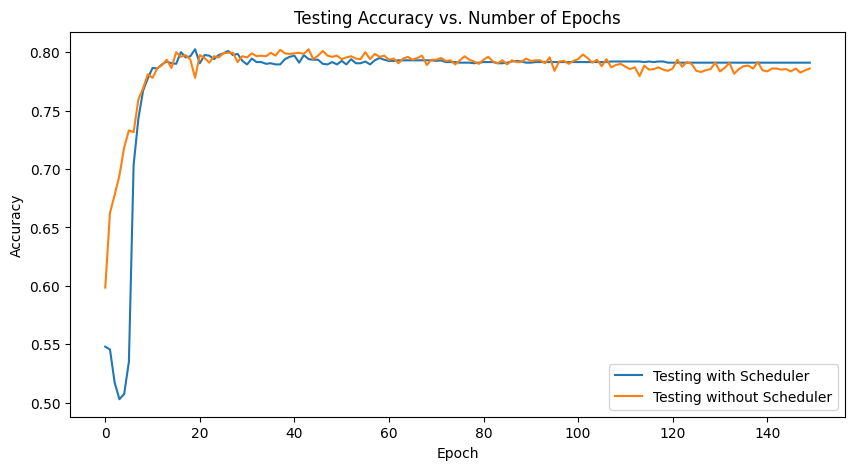

In [28]:
model_with_scheduler = CustomNN(input_size=512, hidden_size=100, num_layers=4, activation='relu', dropout_prob=0.5)
model_without_scheduler = CustomNN(input_size=512, hidden_size=100, num_layers=4, activation='relu', dropout_prob=0.5)

train_scheduler, test_scheduler = experiment_with_scheduler(model_with_scheduler, train_loader, test_loader)
train_noscheduler, test_noscheduler = experiment(model_without_scheduler)

scheduler_train_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(train_scheduler)]
scheduler_test_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(test_scheduler)]

noscheduler_train_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(train_noscheduler)]
noscheduler_test_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(test_noscheduler)]


# Plot training accuracies
plt.figure(figsize=(10, 5))
plt.plot(scheduler_train_accuracies, label='Training with Scheduler')
plt.plot(noscheduler_train_accuracies, label='Training without Scheduler')
plt.title('Training Accuracy vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot testing accuracies
plt.figure(figsize=(10, 5))
plt.plot(scheduler_test_accuracies, label='Testing with Scheduler')
plt.plot(noscheduler_test_accuracies, label='Testing without Scheduler')
plt.title('Testing Accuracy vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### <font color="red">Analysis and discussion here (< 15 sentences) :</font>

In the experiment, a learning rate scheduler was applied to a neural network during training, and its performance was compared against an identical network trained without a scheduler. The scheduler's purpose is to adjust the learning rate at certain intervals, which theoretically helps the model to converge more effectively by taking larger steps when far from the optimum and smaller steps when closer.

The training accuracy plot indicates that the scheduler may contribute to a faster initial increase in accuracy. This suggests that the learning rate adjustments are helping the network to avoid early plateaus or local minima that can trap the optimization process when using a constant learning rate.

For testing accuracy, both models display similar performance throughout training, indicating that the learning rate scheduler does not have a significant detrimental effect on the network's ability to generalize. In fact, there are points where the model with the scheduler appears to have a smoother accuracy curve, which might imply enhanced stability in learning due to the adjusted learning rate steps.

The periodic drops in training accuracy for the model with the scheduler correspond to the points at which the learning rate is reduced. These drops are followed by recovery, demonstrating the model's ability to refine its parameters in response to the new learning rate, which may lead to better generalization in some cases.

### Add a L2 regularization

[512, 256, 128, 64, 2]
[512, 128, 128, 128, 2]
Epoch #10: 	 train accuracy 0.820	 train loss -0.781	 test accuracy 0.785	 test loss -0.763
Epoch #20: 	 train accuracy 0.891	 train loss -0.878	 test accuracy 0.791	 test loss -0.785
Epoch #30: 	 train accuracy 0.924	 train loss -0.917	 test accuracy 0.793	 test loss -0.788
Epoch #40: 	 train accuracy 0.944	 train loss -0.938	 test accuracy 0.789	 test loss -0.787
Epoch #50: 	 train accuracy 0.951	 train loss -0.948	 test accuracy 0.786	 test loss -0.783
Epoch #60: 	 train accuracy 0.964	 train loss -0.960	 test accuracy 0.779	 test loss -0.779
Epoch #70: 	 train accuracy 0.966	 train loss -0.964	 test accuracy 0.779	 test loss -0.781
Epoch #80: 	 train accuracy 0.971	 train loss -0.970	 test accuracy 0.782	 test loss -0.782
Epoch #90: 	 train accuracy 0.971	 train loss -0.971	 test accuracy 0.779	 test loss -0.781
Epoch #100: 	 train accuracy 0.974	 train loss -0.972	 test accuracy 0.782	 test loss -0.782
Epoch #110: 	 train accuracy 0.9

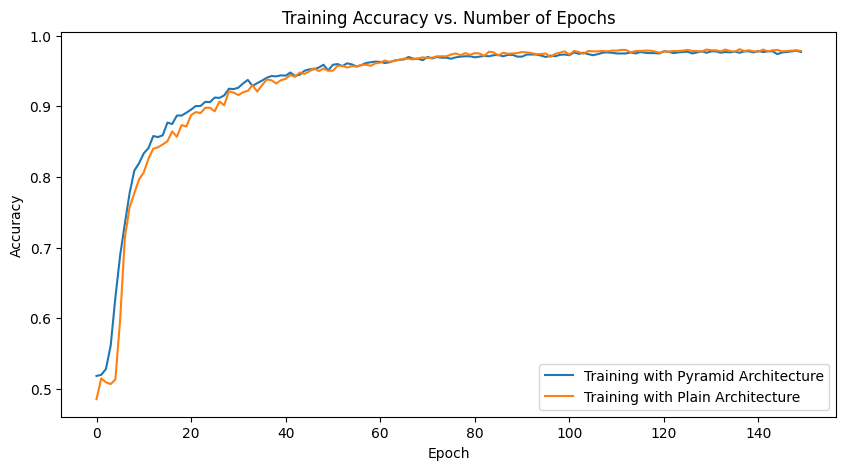

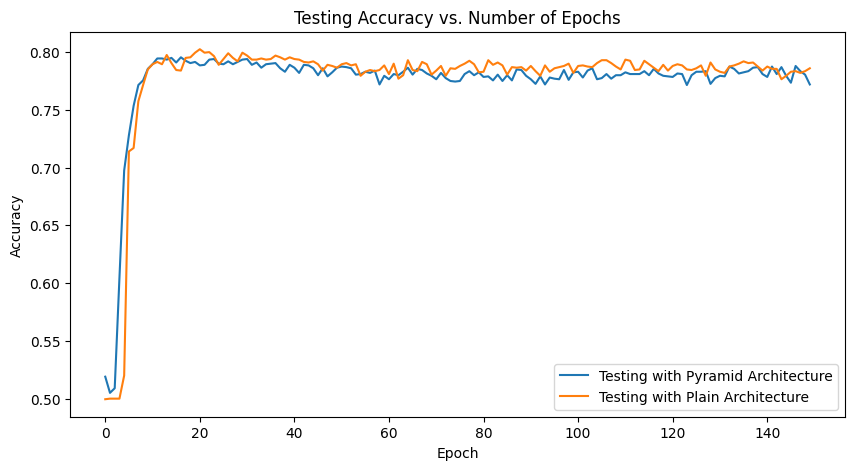

In [29]:
### Add a batch normalization layer
class NN_pyramid(nn.Module):
    def __init__(self, num_layers, activation='relu', dropout_prob=0.5):
        super().__init__()
        self.activation = activation
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob  
        layers = []
        sizes = [512, 256, 128, 64, 2]

        print(sizes)
        for i in range(num_layers):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            if dropout_prob > 0:
                layers.append(nn.Dropout(dropout_prob))
        
        self.layers = nn.Sequential(*layers[:-1])  # Exclude the last activation or dropout for the output layer

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = F.softmax(x, dim=1)  # Apply Softmax to obtain output probabilities.
        return x

model_pyramid = NN_pyramid(num_layers=4, activation='relu')
model_plain = CustomNN(input_size=512, hidden_size=128, num_layers=4, activation='relu', dropout_prob=0.5)
train_pyramid, test_pyramid = experiment(model_pyramid)
train_plain, test_plain = experiment(model_plain)

pyramid_train_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(train_pyramid)]
pyramid_test_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(test_pyramid)]

plain_train_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(train_plain)]
plain_test_accuracies = [np.mean(epoch_acc) for epoch_acc in zip(test_plain)]


# Plot training accuracies
plt.figure(figsize=(10, 5))
plt.plot(pyramid_train_accuracies, label='Training with Pyramid Architecture')
plt.plot(plain_train_accuracies, label='Training with Plain Architecture')
plt.title('Training Accuracy vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot testing accuracies
plt.figure(figsize=(10, 5))
plt.plot(pyramid_test_accuracies, label='Testing with Pyramid Architecture')
plt.plot(plain_test_accuracies, label='Testing with Plain Architecture')
plt.title('Testing Accuracy vs. Number of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### <font color="red">Analysis and discussion here (< 15 sentences) :</font>
In this experiment, two neural network architectures were compared: one with a pyramid structure that gradually reduces the size of its layers, and another with a plain structure having equal-sized layers. Both architectures used ReLU activations and incorporated dropout.

The training accuracy plot reveals that both models perform almost identically throughout the training process, with neither showing a clear advantage over the other. In terms of testing accuracy, again, both models exhibit comparable performance across epochs, suggesting that the pyramid architecture did not provide a significant benefit in this context.

Given these results, it could be hypothesized that the complexity of the task does not require the representational power that a pyramid structure might offer, or that the data is not sufficiently complex to benefit from the increased depth and reduction in dimensionality. The dropout used in both models could also be compensating for any overfitting, leveling the playing field between the two architectures.

Therefore, although the pyramid architecture is often touted for its ability to capture more abstract representations in deeper layers with fewer neurons, in this specific instance, it did not demonstrate superior performance compared to a plain architecture. This suggests that simply changing the architecture to a pyramid form, in the absence of other modifications or a more complex dataset, might not always lead to improved performance.

----------------------------
# <font color="blue"> Submission Instructions</font>
---------------------------

1. Click the Save button at the top of the Jupyter Notebook.
2. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of all cells).
2. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
3. Once you've rerun everything, select File -> Download as -> PDF via LaTeX (If you have trouble using "PDF via LaTex", you can also save the webpage as pdf. <font color='blue'> Make sure all your solutions  are displayed in the pdf</font>, it's okay if the provided codes get cut off because lines are not wrapped in code cells).
4. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
5. Submit your PDF on Gradescope.
